<a href="https://colab.research.google.com/github/CanKeles5/SequenceModels/blob/main/TEIA%C5%9E_LSTM_predict_NG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To-Do:
  Train using only one feature. NaturalGas

  Inspect the data and drop columns that are too sparse. See how many of the values in each col are zero.

++++ 1-  Give all features except total and natural gas and predict NG.


2-  Use 1-2 years data and do forecasting. 

In [1]:
import torch
torch.cuda.is_available()
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [2]:
device

device(type='cuda', index=0)

In [3]:
%matplotlib inline

In [4]:
! pip install pickle5

     |████████████████████████████████| 133kB 9.0MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218620 sha256=99cac8a945988de9b64177f24dc4817023e486914384548d9e233bdb01cc99e2
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [5]:
import pickle5
from math import sqrt
from datetime import datetime
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
with open('/content/20210101-epias-raw.pkl', 'rb') as f:
    data = pickle5.load(f)

Drop all colums of zeros: df.loc[:, (df != 0).any(axis=0)]


In [7]:
new_data = data.loc[:, (data != 0).any(axis=0)] #(index=False)

In [8]:
new_data = new_data.sample(frac = 1)

In [9]:
new_data = new_data.drop(['date', 'ltotal',	'lwind',	'lbiogas',	'lcanalType',	'lbiomass',	'lsun',	'lothers', 'total'], axis=1)

In [10]:
new_data

,fueloil,blackCoal,lignite,geothermal,naturalGas,river,dammedHydro,lng,biomass,naphta,importCoal,asphaltiteCoal,wind,sun,importExport
35444,170.4,206.50,3681.27,530.22,8509.52,4053.00,5411.87,0.00,216.18,0.0,3911.44,381.97,3362.61,0.00,0.00
58870,34.5,279.00,4167.24,1154.77,8456.96,1155.01,1302.93,0.00,406.03,0.0,8749.60,344.44,4623.52,0.00,-176.45
35663,172.7,254.50,4366.89,607.43,8405.57,4027.56,3854.92,0.00,211.43,0.0,3493.44,384.17,530.88,0.00,0.00
14382,288.5,479.00,4032.22,324.63,10638.09,845.36,195.06,4.50,120.81,0.0,4371.90,112.60,696.63,0.00,0.00
66584,36.3,466.19,4707.21,1140.06,13058.31,994.23,5671.80,0.00,526.29,0.0,7806.26,112.60,1727.18,202.91,-365.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66615,36.2,338.29,4347.39,1173.53,12640.42,1001.69,8201.61,0.00,531.72,0.0,8556.42,150.13,1197.82,0.00,-378.33
47167,194.6,273.50,4947.68,678.48,12546.17,1141.68,5727.98,0.00,255.04,0.0,6593.95,331.18,3694.58,17.60,-205.00
1371,28.5,150.00,2403.50,0.00,11144.26,87.01,1286.82,9.10,54.51,0.0,2423.00,0.00,234.01,0.00,0.00
28980,188.8,331.50,4619.97,424.05,12412.89,1310.25,7487.21,10.31,163.12,0.0,6485.67,390.80,2910.01,0.00,0.00


In [11]:
target = new_data.drop(['fueloil',	'blackCoal',	'lignite',	'geothermal',	'river',	'dammedHydro',	'lng',	'biomass',	'naphta',	'importCoal',	'asphaltiteCoal',	'wind',	'sun',	'importExport'], axis=1)

In [12]:
target = target.to_numpy()

In [13]:
data = new_data.drop(['naturalGas'], axis=1)

In [14]:
data = data.to_numpy()

To-do:
  Get the data in such a format that it can work with the other notebook.
  
  1- Extract the date element.

  2- Normalize all features in the input part of the data.

  3- Create the inputs and the targets.

  4- Create train and test sets.

  5- 

  6- 

In [15]:
# integer encode direction
#encoder = LabelEncoder()
#new_data[:,4] = encoder.fit_transform(new_data[:,4])
# ensure all data is float

#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
target = scaler.fit_transform(target)

print(data.shape)
print(target.shape)
#reframed = series_to_supervised(scaled, n_hours, 1)
#print(reframed.shape)

(67268, 14)
(67268, 1)


In [16]:
n_train_hours = 50000
train_X = data[:n_train_hours, :]
train_y = target[:n_train_hours, :]
test_X = data[n_train_hours:, :]
test_y = target[n_train_hours:, :]

In [19]:
class LSTM(nn.Module):

  def __init__(self):
    super(LSTM, self).__init__()

    self.lstm = nn.LSTM(input_size=14, hidden_size=100, num_layers=2)
    self.FC = nn.Linear(100, 1)

  def forward(self, input):
    pred, _ = self.lstm(input)

    pred = self.FC(pred.view(100))

    return pred

In [20]:
model = LSTM().to(device)

In [21]:
sum(p.numel() for p in model.parameters())

127301

In [22]:
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [23]:
train_loss_hist = []
test_loss_hist = []

In [ ]:
for epoch in range(50):
  train_loss = 0.0
  test_loss = 0.0

  for i in range(train_X.shape[0]):
    data = torch.Tensor(train_X[i]).unsqueeze(0).unsqueeze(0)    
    data = data.to(device)

    optimizer.zero_grad()

    prediction = model(data)

    #print("Train --- prediction: " + str(prediction) + " , GT: " + str(train_y[i]))

    loss = loss_function(prediction, torch.Tensor([train_y[i]]).to(device))

    train_loss += loss.item()

    loss.backward()
    optimizer.step()

  with torch.no_grad():
    for i in range(test_X.shape[0]):
      data = torch.Tensor(test_X[i]).unsqueeze(0).unsqueeze(0)
      data = data.to(device)

      prediction = model(data)

      #print("Validate --- prediction: " + str(prediction) + " , GT: " + str(test_y[i]))

      loss = loss_function(prediction, torch.Tensor([test_y[i]]).to(device))
      test_loss += loss.item()

  train_loss = train_loss / train_X.shape[0]
  test_loss = test_loss / test_X.shape[0]

  train_loss_hist.append(train_loss)
  test_loss_hist.append(test_loss)

  print("Train loss: " +  str(train_loss) + " --- Test loss: " + str(test_loss))


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Train loss: 0.0877247029330954 --- Test loss: 0.08842083544552133


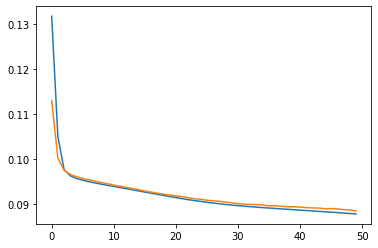

In [25]:
pyplot.plot(train_loss_hist)
pyplot.plot(test_loss_hist)
